<a href="https://colab.research.google.com/github/bubuloMallone/NeuralNetworksEX/blob/main/nn_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

In [130]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  # print nice representation of a Value object
  def __repr__(self):
    return f"Value(data={self.data})"

  # a + b  -->  a.__add__(b)
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other): # other + self
        return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward

    return out

  # fallback to allow also other * self
  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __rtruediv__(self, other): # other / self
        return other * self**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rsub__(self, other): # other - self
        return other + (-self)


  def exp (self):
    x = self.data
    e = math.exp(x)
    out = Value(e, (self, ), 'exp')

    def _backward():
      self.grad +=  out.data * out.grad
    out._backward = _backward
    return out


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1.0 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()

    def build_topo(parent_node):
      if parent_node not in visited:
        visited.add(parent_node)
        for child in parent_node._prev:
          build_topo(child)
        topo.append(parent_node)

    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [58]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')

c = a + b; c.label='c'
e = a*b; e.label='e'
d = e + c; d.label='d'

f = Value(-2.0, label='f')
L = d * f; L.label='L'

print(c)
print(d)
print(d._prev)
print(d._op)

Value(data=-1.0)
Value(data=-7.0)
{Value(data=-1.0), Value(data=-6.0)}
+


In [59]:
# Visualization of graph operations

from graphviz import Digraph

def trace(root):
  # build a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ % s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an operation node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

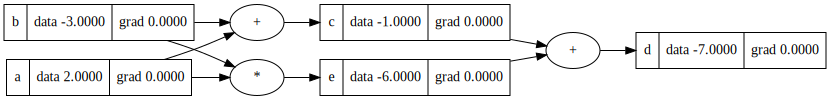

In [60]:
draw_dot(d)

Manually compute derivatives

In [61]:
def lol():

  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = a + b; c.label='c'
  e = a*b; e.label='e'
  d = e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = a + b; c.label='c'
  e = a*b; e.label='e'
  d = e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L2 = L.data + h

  print((L2 - L1) / h)

lol()

0.9999999999976694


Now want to run backpropagation on this graph, i.e. determining the derivative of the output L wrt the nodes in the graph, according to the chain rule

Single layer perceptron

In [83]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88137358702, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

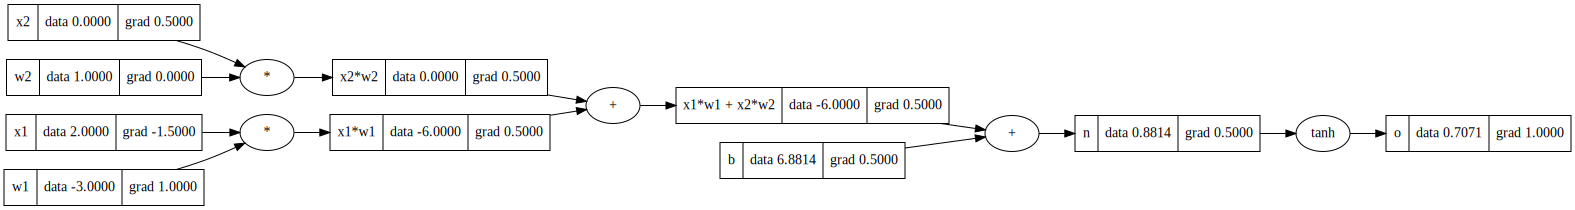

In [93]:
draw_dot(o)

In [85]:
o.grad = 1.0
o._backward()

In [87]:
n._backward()

In [89]:
b._backward()
x1w1x2w2._backward()

In [92]:
x1w1._backward()
x2w2._backward()

Use Topological Sort to create an ordered graph and automate the flow of backpropagation through the network

In [105]:
topo = []
visited = set()
def build_topo(parent_node):
  if parent_node not in visited:
    visited.add(parent_node)
    for child in parent_node._prev:
      build_topo(child)
    topo.append(parent_node)

In [97]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88137358702, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

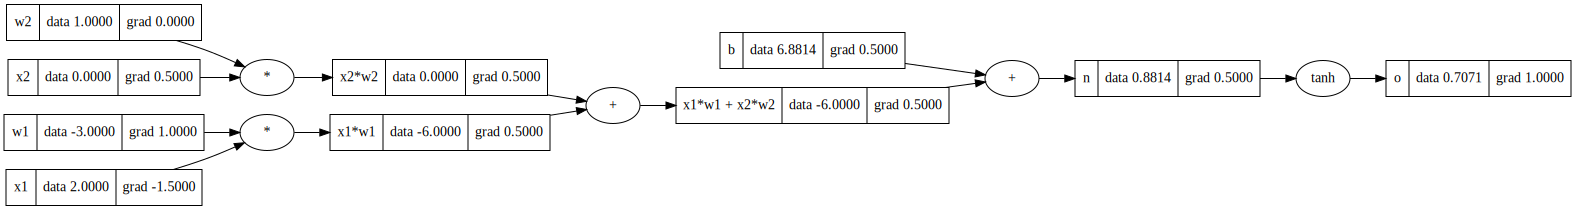

In [110]:
draw_dot(o)

In [109]:
o.grad = 1.0
build_topo(o)

for node in reversed(topo):
  node._backward()

Now we can integrate this notion of the topological sort as a method inside the Value class. We call this backward(), and will expliot the operation-specific _backward() methods.

In [111]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88137358702, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

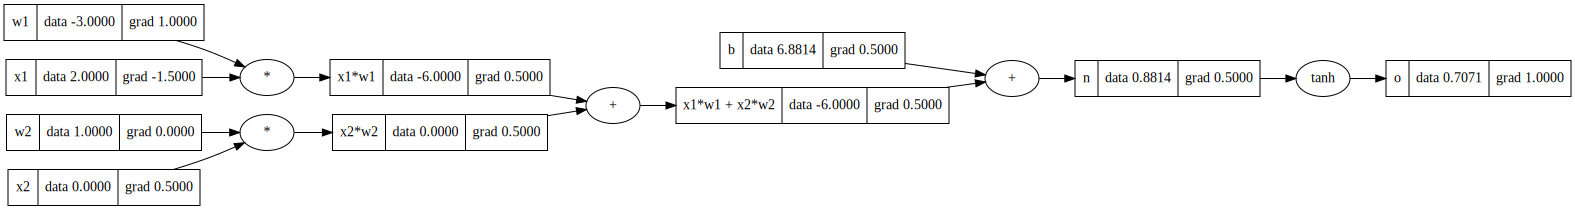

In [114]:
draw_dot(o)

In [113]:
o.backward()

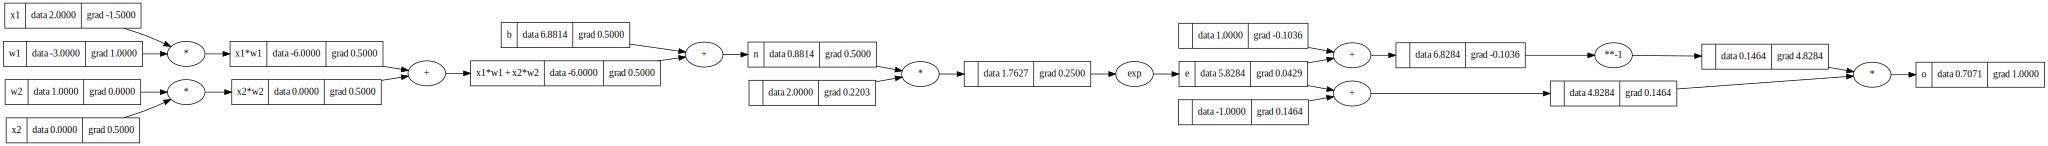

In [117]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88137358702, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp() ; e.label = 'e'
o = (e - 1) / (e + 1)
o.label = 'o'
# ----
o.backward()
draw_dot(o)

How does this work in pytorch?

In [ ]:
import torch

In [118]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.88137358702]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Now, build a neural net library (multi-layer perceptron)

In [135]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  # forward pass: w * x + b
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):

    # params = []
    # for neuron in self.neurons:
    #   params.extend(neuron.parameters())
    # return params

    return [p for neuron in self.neurons for p in neuron.parameters()]



class MLP:
  def __init__(self, nin, nouts):
    size = [nin] + nouts
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


Value(data=-0.7040431986865787)


In [ ]:
# examples
x = [1.0, -2.0, 3.0]
# n = Neuron(2)
# print(n(x))
# l = Layer(2,3)
# print(l(x))

mlp = MLP(nin= 3, nouts= [2,3,1])
print(mlp(x))

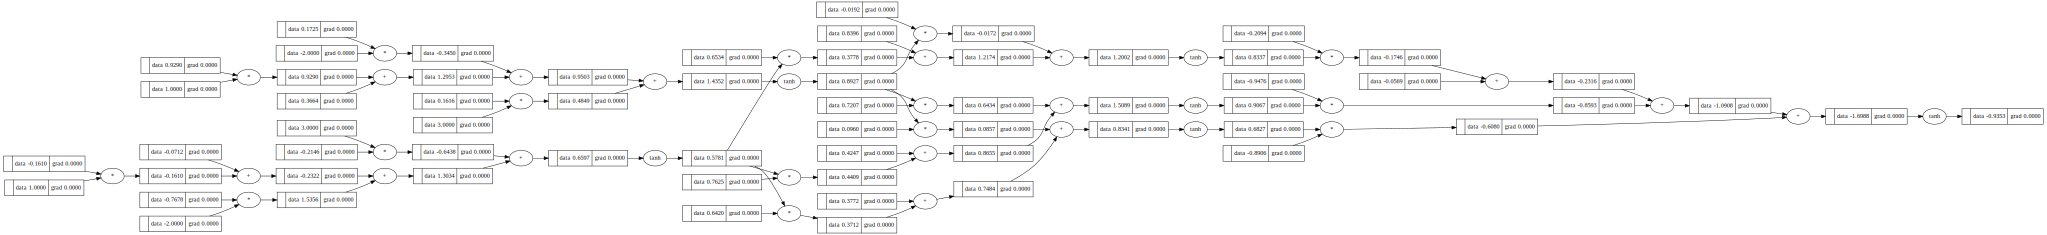

In [123]:
draw_dot(mlp(x))

Let us implement a simple binary classifier with our multi-layer perceptron

In [144]:
x = [1.0, -2.0, 3.0]
mlp = MLP(nin= 3, nouts= [2,3,1])

In [145]:
# dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
# labels
ys = [1.0, -1.0, -1.0, 1.0]

Define the Loss Function for the binary classifier

In [137]:
loss = sum((y_out - y_true)**2 for y_true, y_out in zip(ys, ypred))
loss

Value(data=5.8419054541078586)

In [138]:
loss.backward()
mlp.layers[0].neurons[0].w[0]

Value(data=0.2508273595086894)

In [196]:
learning_rate = 0.05
n_steps = 30

for k in range (n_steps):

  # forward pass
  y_pred = [mlp(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))

  # backward pass
  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()

  # update weights
  for p in mlp.parameters():
    p.data += - learning_rate * p.grad

  print(k, loss.data)

0 0.0003403453782855323
1 0.0003401092470133559
2 0.0003398734390757044
3 0.0003396379538125391
4 0.00033940279056560987
5 0.00033916794867844144
6 0.0003389334274963518
7 0.00033869922636641105
8 0.0003384653446374742
9 0.00033823178166013867
10 0.00033799853678676516
11 0.00033776560937146666
12 0.0003375329987700804
13 0.00033730070434018916
14 0.0003370687254411214
15 0.00033683706143390407
16 0.00033660571168129877
17 0.00033637467554776965
18 0.00033614395239949636
19 0.00033591354160436213
20 0.0003356834425319306
21 0.00033545365455347017
22 0.0003352241770419301
23 0.0003349950093719389
24 0.00033476615091978786
25 0.0003345376010634477
26 0.0003343093591825526
27 0.0003340814246583795
28 0.00033385379687387207
29 0.00033362647521360697


In [197]:
y_pred = [mlp(x) for x in xs]
y_pred

[Value(data=0.9921408607175505),
 Value(data=-0.9937759991535786),
 Value(data=-0.9910786979279415),
 Value(data=0.9876183372842863)]